### Download Dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vijayveersingh/1-2m-brain-signal-data")

print("Path to dataset files:", path)

100%|██████████| 618M/618M [00:22<00:00, 28.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vijayveersingh/1-2m-brain-signal-data/versions/1


### List Dataset Contents

In [2]:
import os

dataset_path = path

# List the contents of the downloaded dataset directory
print("Contents of the dataset directory:")
for root, dirs, files in os.walk(dataset_path):
    print(f"Directory: {root}")
    for name in files:
        print(f"  File: {name}")

Contents of the dataset directory:
Directory: /root/.cache/kagglehub/datasets/vijayveersingh/1-2m-brain-signal-data/versions/1
Directory: /root/.cache/kagglehub/datasets/vijayveersingh/1-2m-brain-signal-data/versions/1/MindBigData-IN-v1.06
  File: IN.txt
Directory: /root/.cache/kagglehub/datasets/vijayveersingh/1-2m-brain-signal-data/versions/1/MindBigData-MW-v1.0
  File: MW.txt
Directory: /root/.cache/kagglehub/datasets/vijayveersingh/1-2m-brain-signal-data/versions/1/MindBigData-EP-v1.0
  File: EP1.01.txt
Directory: /root/.cache/kagglehub/datasets/vijayveersingh/1-2m-brain-signal-data/versions/1/MindBigData-MU-v1.0
  File: MU.txt


### Load Data into DataFrame

In [3]:
import pandas as pd
import os

file_path_in = os.path.join(dataset_path, 'MindBigData-IN-v1.06', 'IN.txt')
# Read the file again, specifying no header and providing column names
column_names = ["id", "event", "device", "channel", "code", "size", "data"]
df = pd.read_csv(file_path_in, delimiter='\t', header=None, names=column_names)

### Display DataFrame Head

In [5]:
df.head()

,id,event,device,channel,code,size,data
0,1142043,173652,IN,AF3,0,256,"4259.487179,4237.948717,4247.179487,4242.05128..."
1,1142044,173652,IN,AF4,0,256,"4103.076923,4100.512820,4102.564102,4087.69230..."
2,1142045,173652,IN,T7,0,256,"4245.128205,4218.461538,4242.051282,4245.12820..."
3,1142046,173652,IN,T8,0,256,"4208.717948,4188.717948,4204.102564,4198.46153..."
4,1142047,173652,IN,PZ,0,256,"4189.230769,4203.589743,4188.717948,4186.66666..."


In [6]:
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch

# Define the sampling rate
fs = 128  # Hz

In [7]:
# Design a 4th order bandpass filter between 0.5 and 40 Hz
lowcut = 0.5
highcut = 40.0
order = 4

nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist

b_bandpass, a_bandpass = butter(order, [low, high], btype='band')

# Create a function to apply the bandpass filter
def bandpass_filter(signal, fs, lowcut, highcut, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

In [8]:
# Design a notch filter at 50 Hz with Q = 30
notch_freq = 50.0  # Hz
Q = 30.0

b_notch, a_notch = iirnotch(notch_freq, Q, fs)

# Create a function to apply the notch filter
def notch_filter(signal, fs, notch_freq, Q):
    b, a = iirnotch(notch_freq, Q, fs)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

In [9]:
# Define the clean_signal function
def clean_signal(signal, fs, lowcut, highcut, notch_freq, Q):
    # Remove DC component
    signal = signal - np.mean(signal)

    # Apply bandpass filter
    signal = bandpass_filter(signal, fs, lowcut, highcut)

    # Apply notch filter
    signal = notch_filter(signal, fs, notch_freq, Q)

    return signal

# Define the normalize function
def normalize(signal):
    # Zero mean and unit standard deviation (standardization)
    mean = np.mean(signal)
    std = np.std(signal)
    if std == 0:
        return signal - mean  # Handle case where std is 0
    else:
        return (signal - mean) / std

# Create empty lists to store processed signals and labels
processed = []
labels = []

# Loop through the first 1000 rows of the DataFrame df
for index, row in df.head(1000).iterrows():
    # Convert the "data" column to a numpy array of floats
    signal_data = np.array(row["data"].split(','), dtype=float)

    # Clean the signal
    cleaned_signal = clean_signal(signal_data, fs, lowcut, highcut, notch_freq, Q)

    # Normalize the signal
    normalized_signal = normalize(cleaned_signal)

    # Append the processed signal and label to the lists
    processed.append(normalized_signal)
    labels.append(row["code"])

print("Processing complete for the first 1000 rows.")

Processing complete for the first 1000 rows.


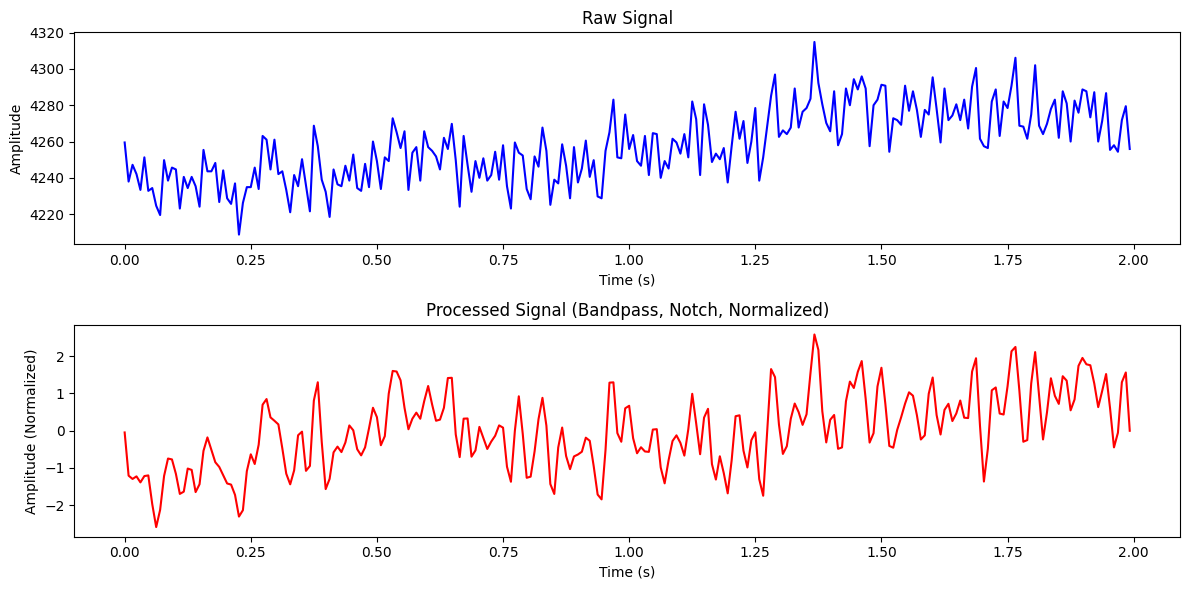

In [11]:
import matplotlib.pyplot as plt

# Select a sample signal to visualize (e.g., the first processed signal)
sample_index = 0
raw_signal_data = np.array(df.head(1000).iloc[sample_index]["data"].split(','), dtype=float)
processed_signal = processed[sample_index]

# Create a time vector for plotting
time = np.arange(len(raw_signal_data)) / fs

# Plot the raw and processed signals
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(time, raw_signal_data, color='blue')
plt.title("Raw Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
plt.plot(time, processed_signal, color='red')
plt.title("Processed Signal (Bandpass, Notch, Normalized)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (Normalized)")

plt.tight_layout()
plt.show()

In [12]:
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch

class EEGPreprocessor:
    def __init__(self, fs=128, lowcut=0.5, highcut=40.0, notch_freq=50.0, order=4, Q=30.0):
        self.fs = fs
        self.lowcut = lowcut
        self.highcut = highcut
        self.notch_freq = notch_freq
        self.order = order
        self.Q = Q

        # Calculate bandpass filter coefficients
        nyquist = 0.5 * self.fs
        low = self.lowcut / nyquist
        high = self.highcut / nyquist
        self.b_bandpass, self.a_bandpass = butter(self.order, [low, high], btype='band')

        # Calculate notch filter coefficients
        self.b_notch, self.a_notch = iirnotch(self.notch_freq, self.Q, self.fs)

    def _bandpass_filter(self, signal):
        return filtfilt(self.b_bandpass, self.a_bandpass, signal)

    def _notch_filter(self, signal):
        return filtfilt(self.b_notch, self.a_notch, signal)

    def _clean_signal(self, signal):
        # Remove DC component
        signal = signal - np.mean(signal)

        # Apply bandpass filter
        signal = self._bandpass_filter(signal)

        # Apply notch filter
        signal = self._notch_filter(signal)

        return signal

    def _normalize(self, signal, epsilon=1e-6):
        # Zero mean and unit standard deviation (standardization)
        mean = np.mean(signal)
        std = np.std(signal)
        return (signal - mean) / (std + epsilon) # Add epsilon to avoid division by zero

    def transform(self, dataframe):
        processed_signals = []
        labels = []

        for index, row in dataframe.iterrows():
            # Convert the "data" column to a numpy array of floats
            signal_data = np.array(row["data"].split(','), dtype=float)

            # Clean the signal
            cleaned_signal = self._clean_signal(signal_data)

            # Normalize the signal
            normalized_signal = self._normalize(cleaned_signal)

            # Append the processed signal and label to the lists
            processed_signals.append(normalized_signal)
            labels.append(row["code"])

        return processed_signals, labels